In [2]:
library(tidyverse)
library(tidymodels)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# A Weekend Article Prediction Model

Mashable is an online news source that covers digital culture, social media and technology, similar to The Verge and TechCrunch. The dataset we are looking at contains information about articles published by Mashable in a period of two years. The original goal of the dataset that was collected by UC Irvine was to predict the number of shares in social networks (popularity) for each article published on Mashable. For our project, we will create a model that can be used to determine whether an article by Mashable was published on a weekday or weekend. We will do this by first determining what variables are the most important for the categorization of weekday vs weekend. The online news popularity data set was collected from Mashable and summarizes two years of articles using 61 attributes.

In [3]:
options(repr.matrix.max.rows = 6)
# Here we load and clean the dataset. 
# We remove all non-numeric and publication date related variables.
news_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQqn7Dsf5KqcPHqcwKBwVpLiEczGNRusJeqmw_xhNsheA8anlCokXI7jDfOGfGKwjIENuB7ngwYsAiQ/pub?gid=1905386087&single=true&output=csv") %>%
    filter(!is.na(is_weekend)) %>%
    select(-c(weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday)) %>%
    select(-c(data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world)) %>%
    select(-c(url, timedelta))

# We also transform the is_weekend column to contain the factors Weekday and Weekend instead of 0 and 1 respectively.
news_data$is_weekend <- as.character(news_data$is_weekend)
news_data$is_weekend[news_data$is_weekend == "0"] <- "Weekday"
news_data$is_weekend[news_data$is_weekend == "1"] <- "Weekend"
news_data$is_weekend <- as.factor(news_data$is_weekend)

news_data

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5,-0.1875,0.0,0.1875,593
9,255,0.6047431,1,0.7919463,3,1,1,0,4.913725,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0,0.0000,0.5,0.0000,711
9,211,0.5751295,1,0.6638655,3,1,1,0,4.393365,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0,0.0000,0.5,0.0000,1500
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
10,442,0.5163551,1,0.6441281,24,1,12,1,5.076923,⋯,0.1363636,0.5,-0.3564394,-0.8,-0.1666667,0.4545455,0.1363636,0.04545455,0.1363636,1900
6,682,0.5394933,1,0.6926605,10,1,1,0,4.975073,⋯,0.0625000,0.5,-0.2052455,-0.5,-0.0125000,0.0000000,0.0000000,0.50000000,0.0000000,1100
10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,⋯,0.1000000,0.5,-0.2000000,-0.2,-0.2000000,0.3333333,0.2500000,0.16666667,0.2500000,1300


In [4]:
# Here we separate the data into a training and testing set. 
set.seed(1)
news_split <- initial_split(news_data, prop = 0.5, strata = is_weekend)
news_train <- training(news_split)
news_test <- testing(news_split)

# glimpse(news_train)

Here we scale all variables other an is_weekend (because it is a factor type), so that we can calculate the mean differences between the variables for weekday vs weekend articles.

In [5]:
# Scaling all variables other than is_weekend, then adding it back
news_train_scaled <- select(news_train, -is_weekend) %>%
    scale(center = FALSE) %>%
    data.frame(is_weekend = news_train$is_weekend)

# Table of differences between the weekend vs weekday metrics using the scaled data
news_table_scaled <- group_by(news_train_scaled, is_weekend) %>%
    summarize_all(mean, na.rm = TRUE) %>%
    pivot_longer(cols = n_tokens_title:shares,
                names_to = "variables",
                values_to = "values") %>%
    pivot_wider(names_from = "is_weekend",
               values_from = "values") %>%
    mutate(scaled_mean_diff = abs(Weekday-Weekend)) %>%
    arrange(desc(scaled_mean_diff))
slice(news_table_scaled, 1:5)

variables,Weekday,Weekend,scaled_mean_diff
<chr>,<dbl>,<dbl>,<dbl>
num_hrefs,0.6836021,0.8383238,0.15472166
num_imgs,0.4613575,0.5887637,0.12740614
num_self_hrefs,0.6429533,0.7501674,0.10721405
n_tokens_content,0.7404440,0.8428253,0.10238132
title_sentiment_polarity,0.2485305,0.3481088,0.09957828


Table 1. Here we show the top 5 scaled mean differences between weekday and weekend articles calculated from our training set.

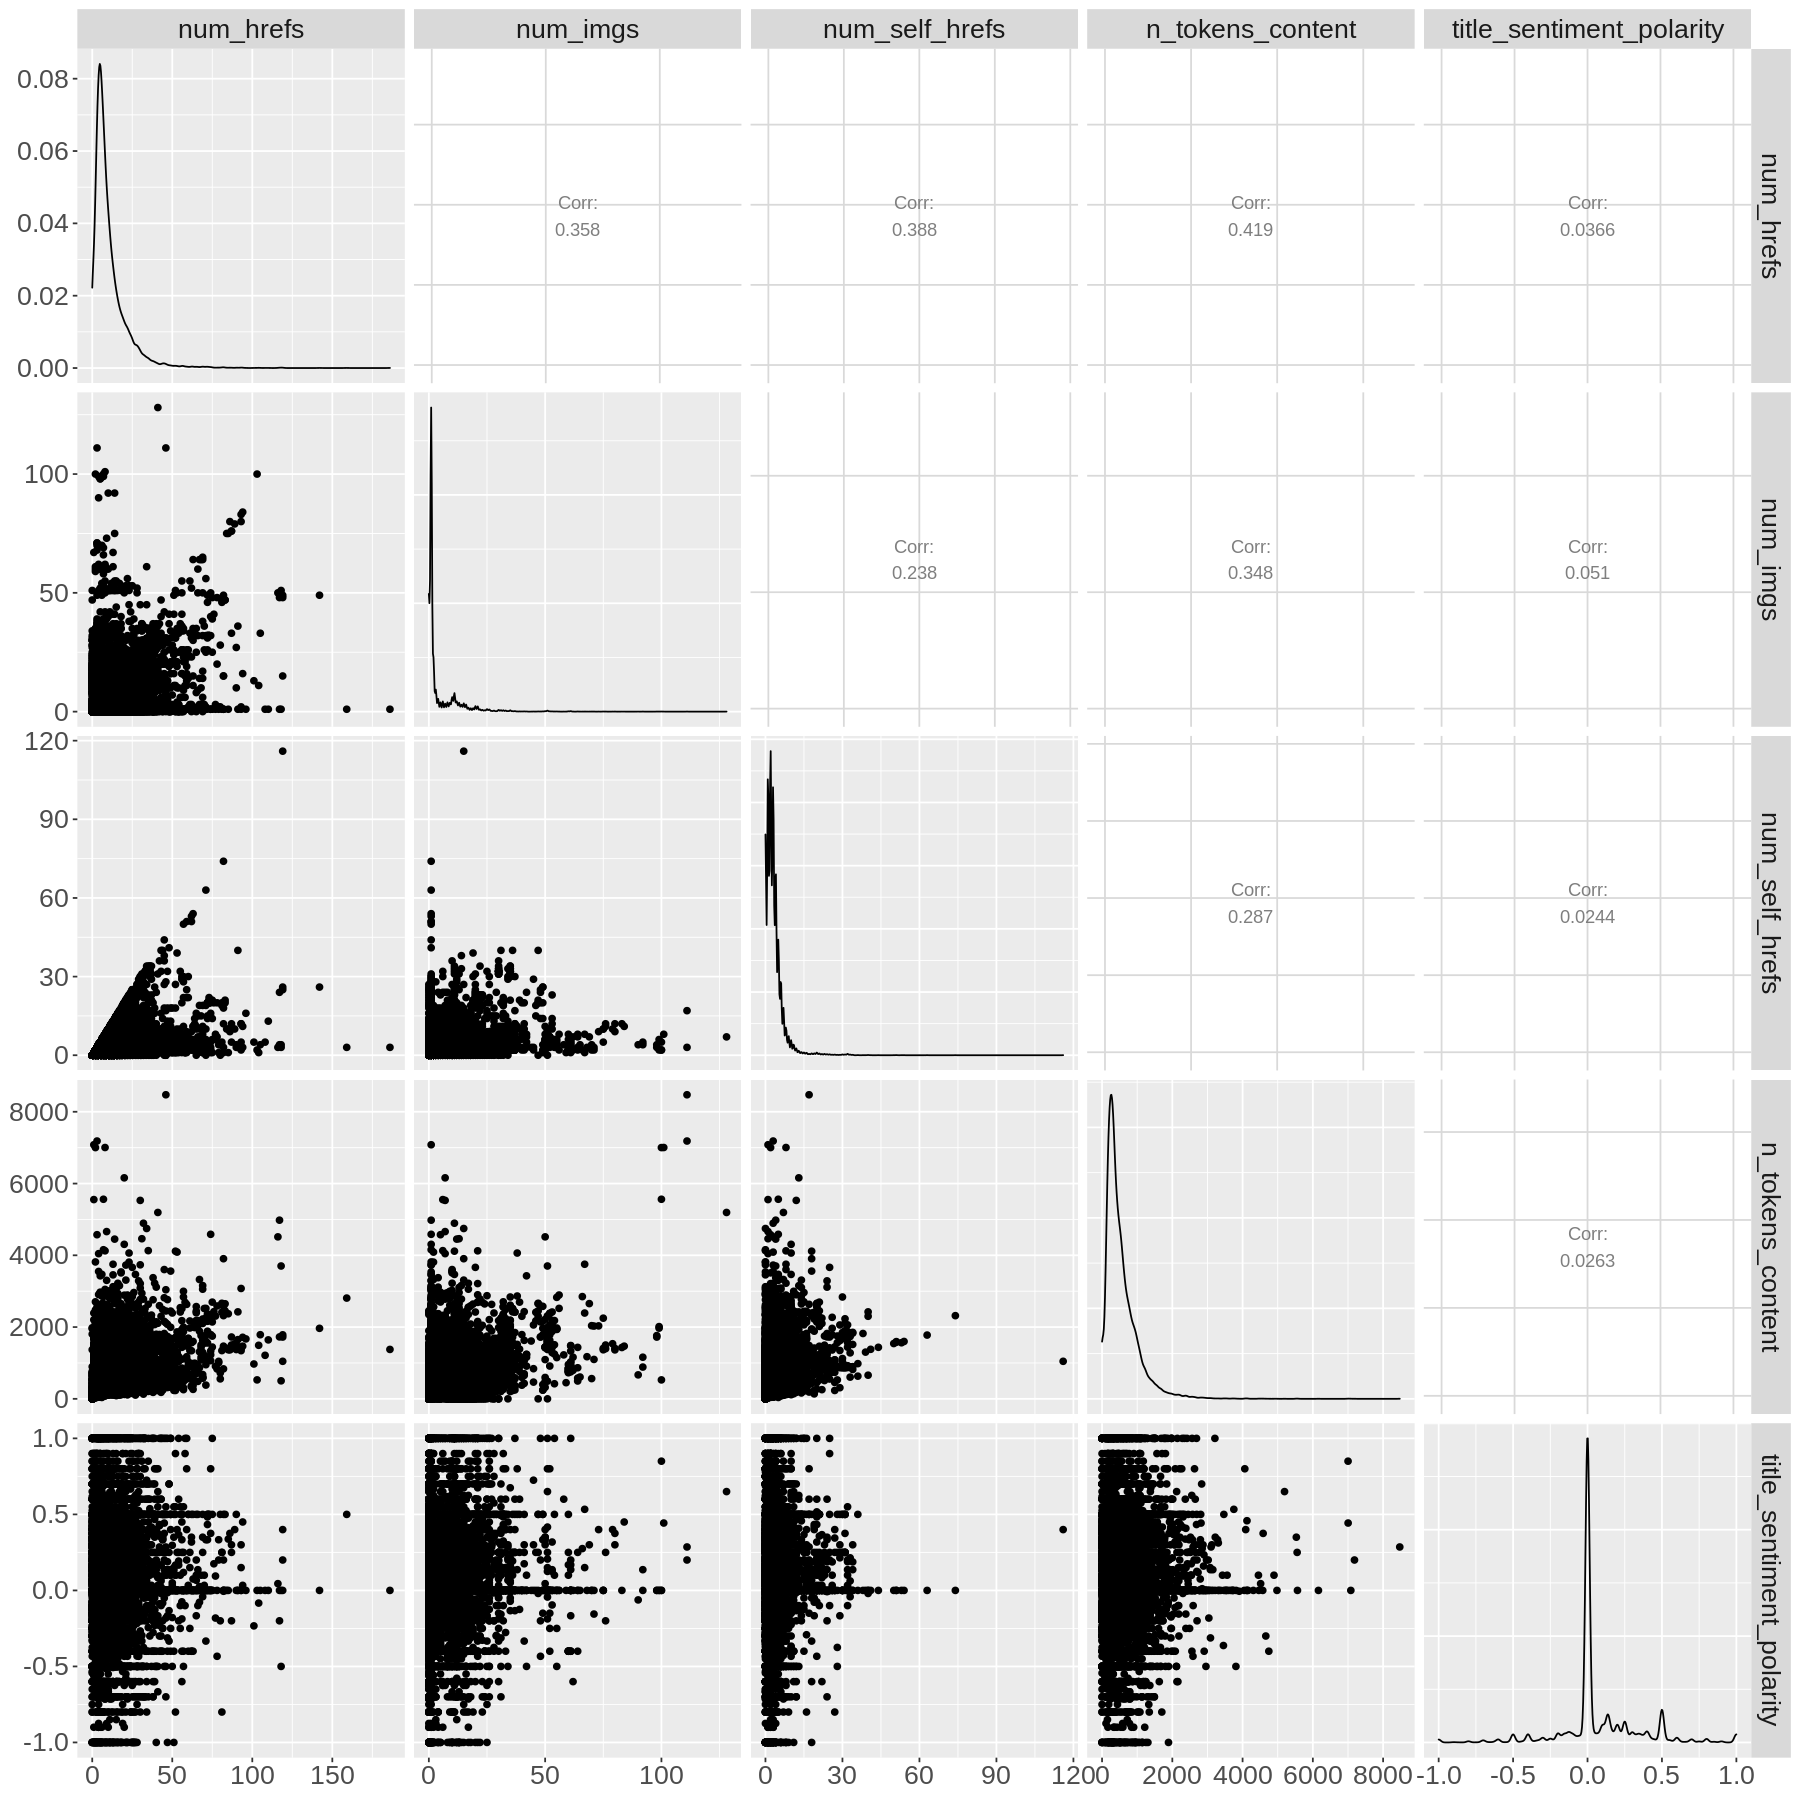

In [7]:
options(repr.plot.width = 15, repr.plot.height = 15) 

plot_pairs <- news_train %>%
    select(num_hrefs, num_imgs, num_self_hrefs, n_tokens_content, title_sentiment_polarity) %>%
    ggpairs() +
    theme(text = element_text(size = 20))
plot_pairs

Here we show a plot for our top 5 scaled mean differences variables using our training data. Scatterplots between the variables are shown on the lower left, distributions are on the diagonal, and correlation coefficients are shown on the top right.

### Methods

Our goal is to use K-nearest neighbours classification to make a model and predict whether future articles were published on weekends. In particular we can use cross-validation with a C value of 5 (as a balance computation time and accuracy) to tune our K value. Because we have just about 40,000 observations, we can afford to use a 50/50 split to divide our training and testing data and still be confident that our model would be sufficiently trained. After our model has been trained, we will use our testing data set to check our model’s accuracy. The variables chosen were based off of their highest mean difference between weekend and non-weekend articles (see table)

### Expected Outcomes and Significance

Given that our table shows little difference between weekend article vs weekday article statistics, our expectations have been set low. However, by giving 5 variables to our model, perhaps there are patterns that KNN can find but we cannot yet see. Ideally, given certain metrics, our model will be able to predict whether an article was published on the weekend or not.

Although the results by themselves are not highly impactful, they could lead to future questions that could be studied. Some of these questions could include: are these metrics intentional? Are publishers pushing an agenda by publishing certain articles on weekdays vs weekends (unlikely, but who knows)? After analyzing the patterns behind the scene, newspaper companies can use the data to further analyze the characteristics of the readers and strategically use it for advertisement, etc.

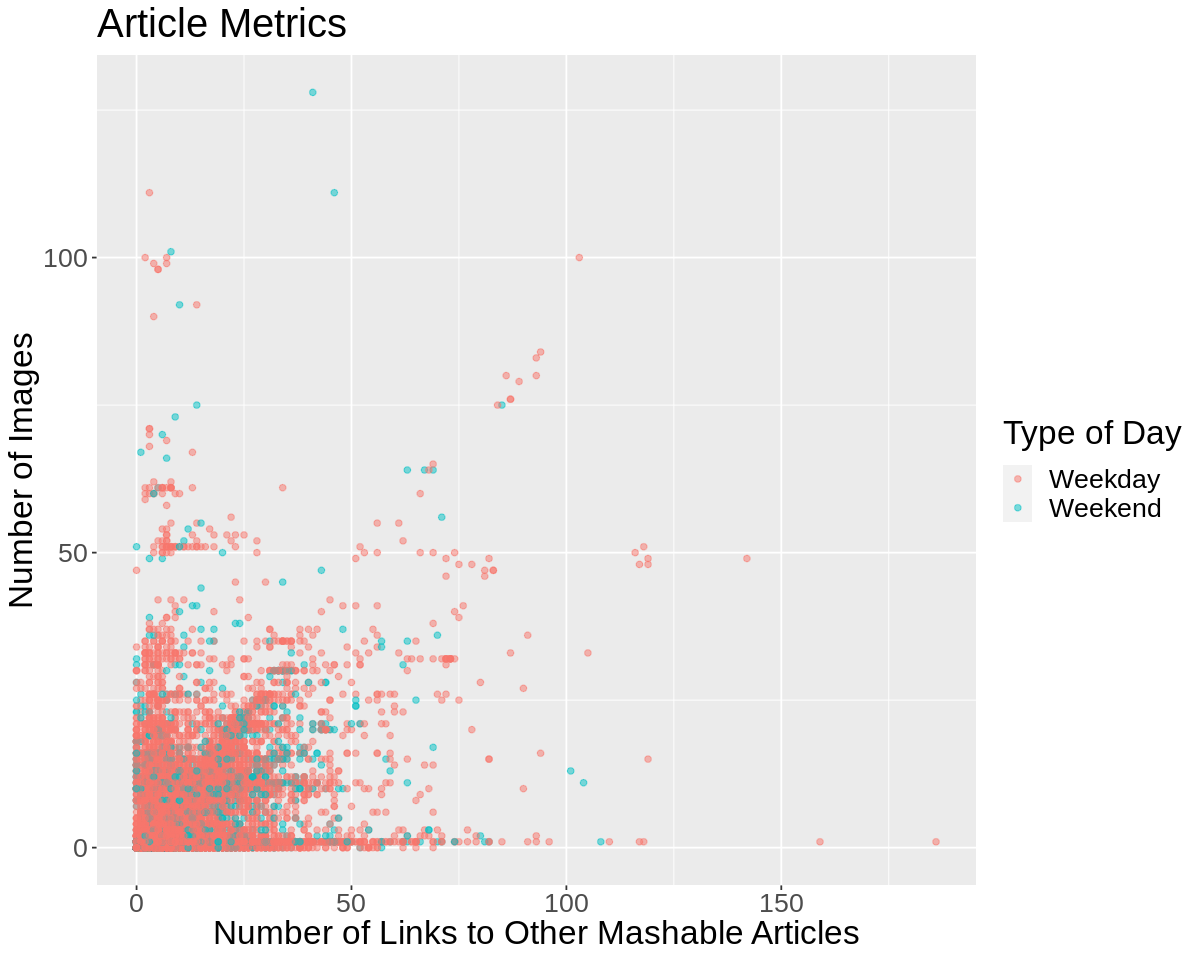

In [6]:
# Plot of 2 highest difference metrics (num_hrefs, and num_imgs)

options(repr.plot.width = 10, repr.plot.height = 8)
news_train_plot <- news_train %>%
    ggplot(aes(x = num_hrefs, y = num_imgs)) +
    geom_point(alpha = 0.5, aes(colour = is_weekend)) +
    labs(title = "Article Metrics",
         x = "Number of Links to Other Mashable Articles",
         y = "Number of Images",
         color = "Type of Day") +
    theme(text = element_text(size=20))
news_train_plot

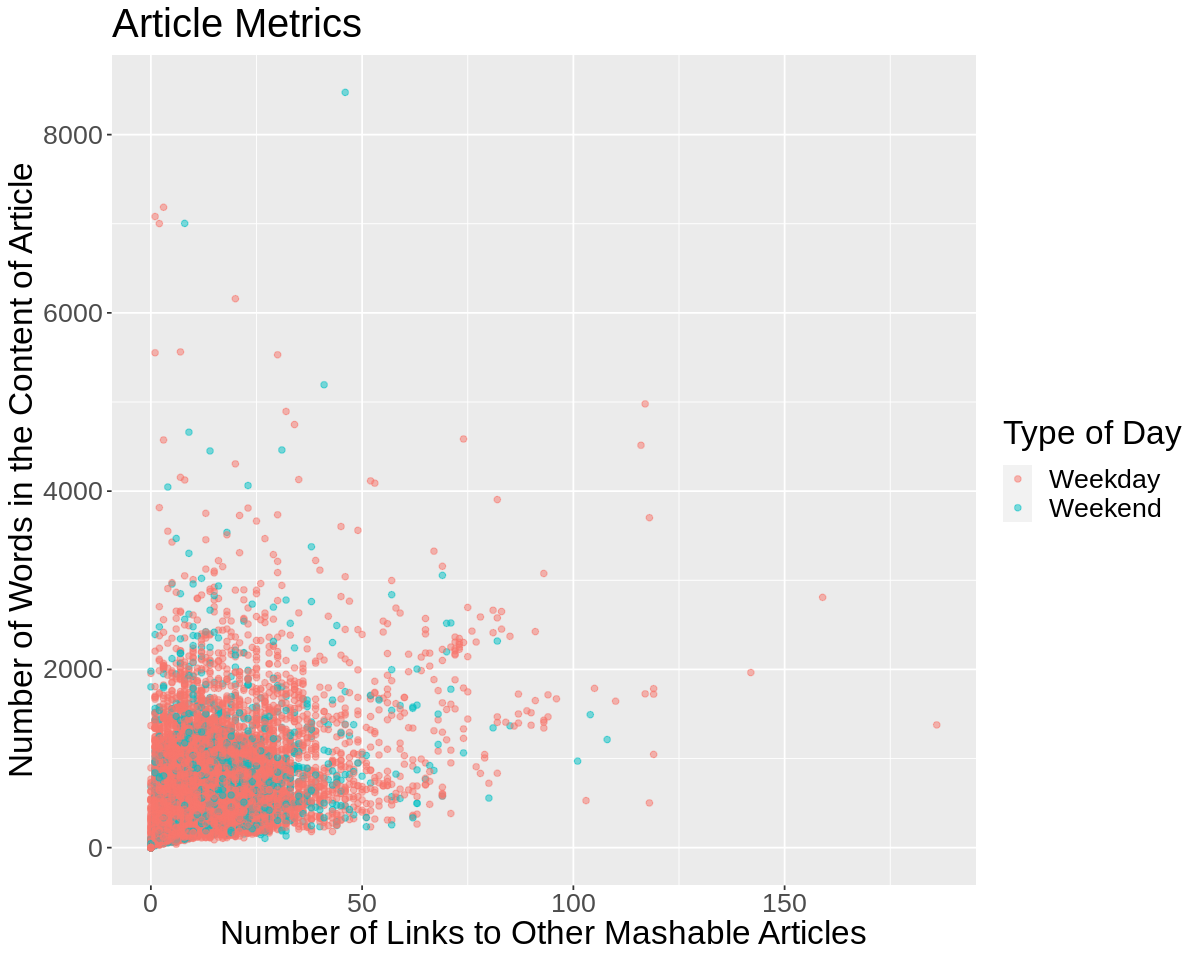

In [7]:
# Plot of 2 highest correlated metrics from the top 5 differences 
# Correlation shown below:

# x <- pull(news_train, num_hrefs)
# y <- pull(news_train, n_tokens_content)
# cor(x, y)

news_train_plot_2 <- news_train %>%
    ggplot(aes(x = num_hrefs, y = n_tokens_content)) +
    geom_point(alpha = 0.5, aes(colour = is_weekend)) +
    labs(title = "Article Metrics", 
         x = "Number of Links to Other Mashable Articles",
         y = "Number of Words in the Content of Article",
         color = "Type of Day") +
    theme(text = element_text(size=20))
news_train_plot_2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



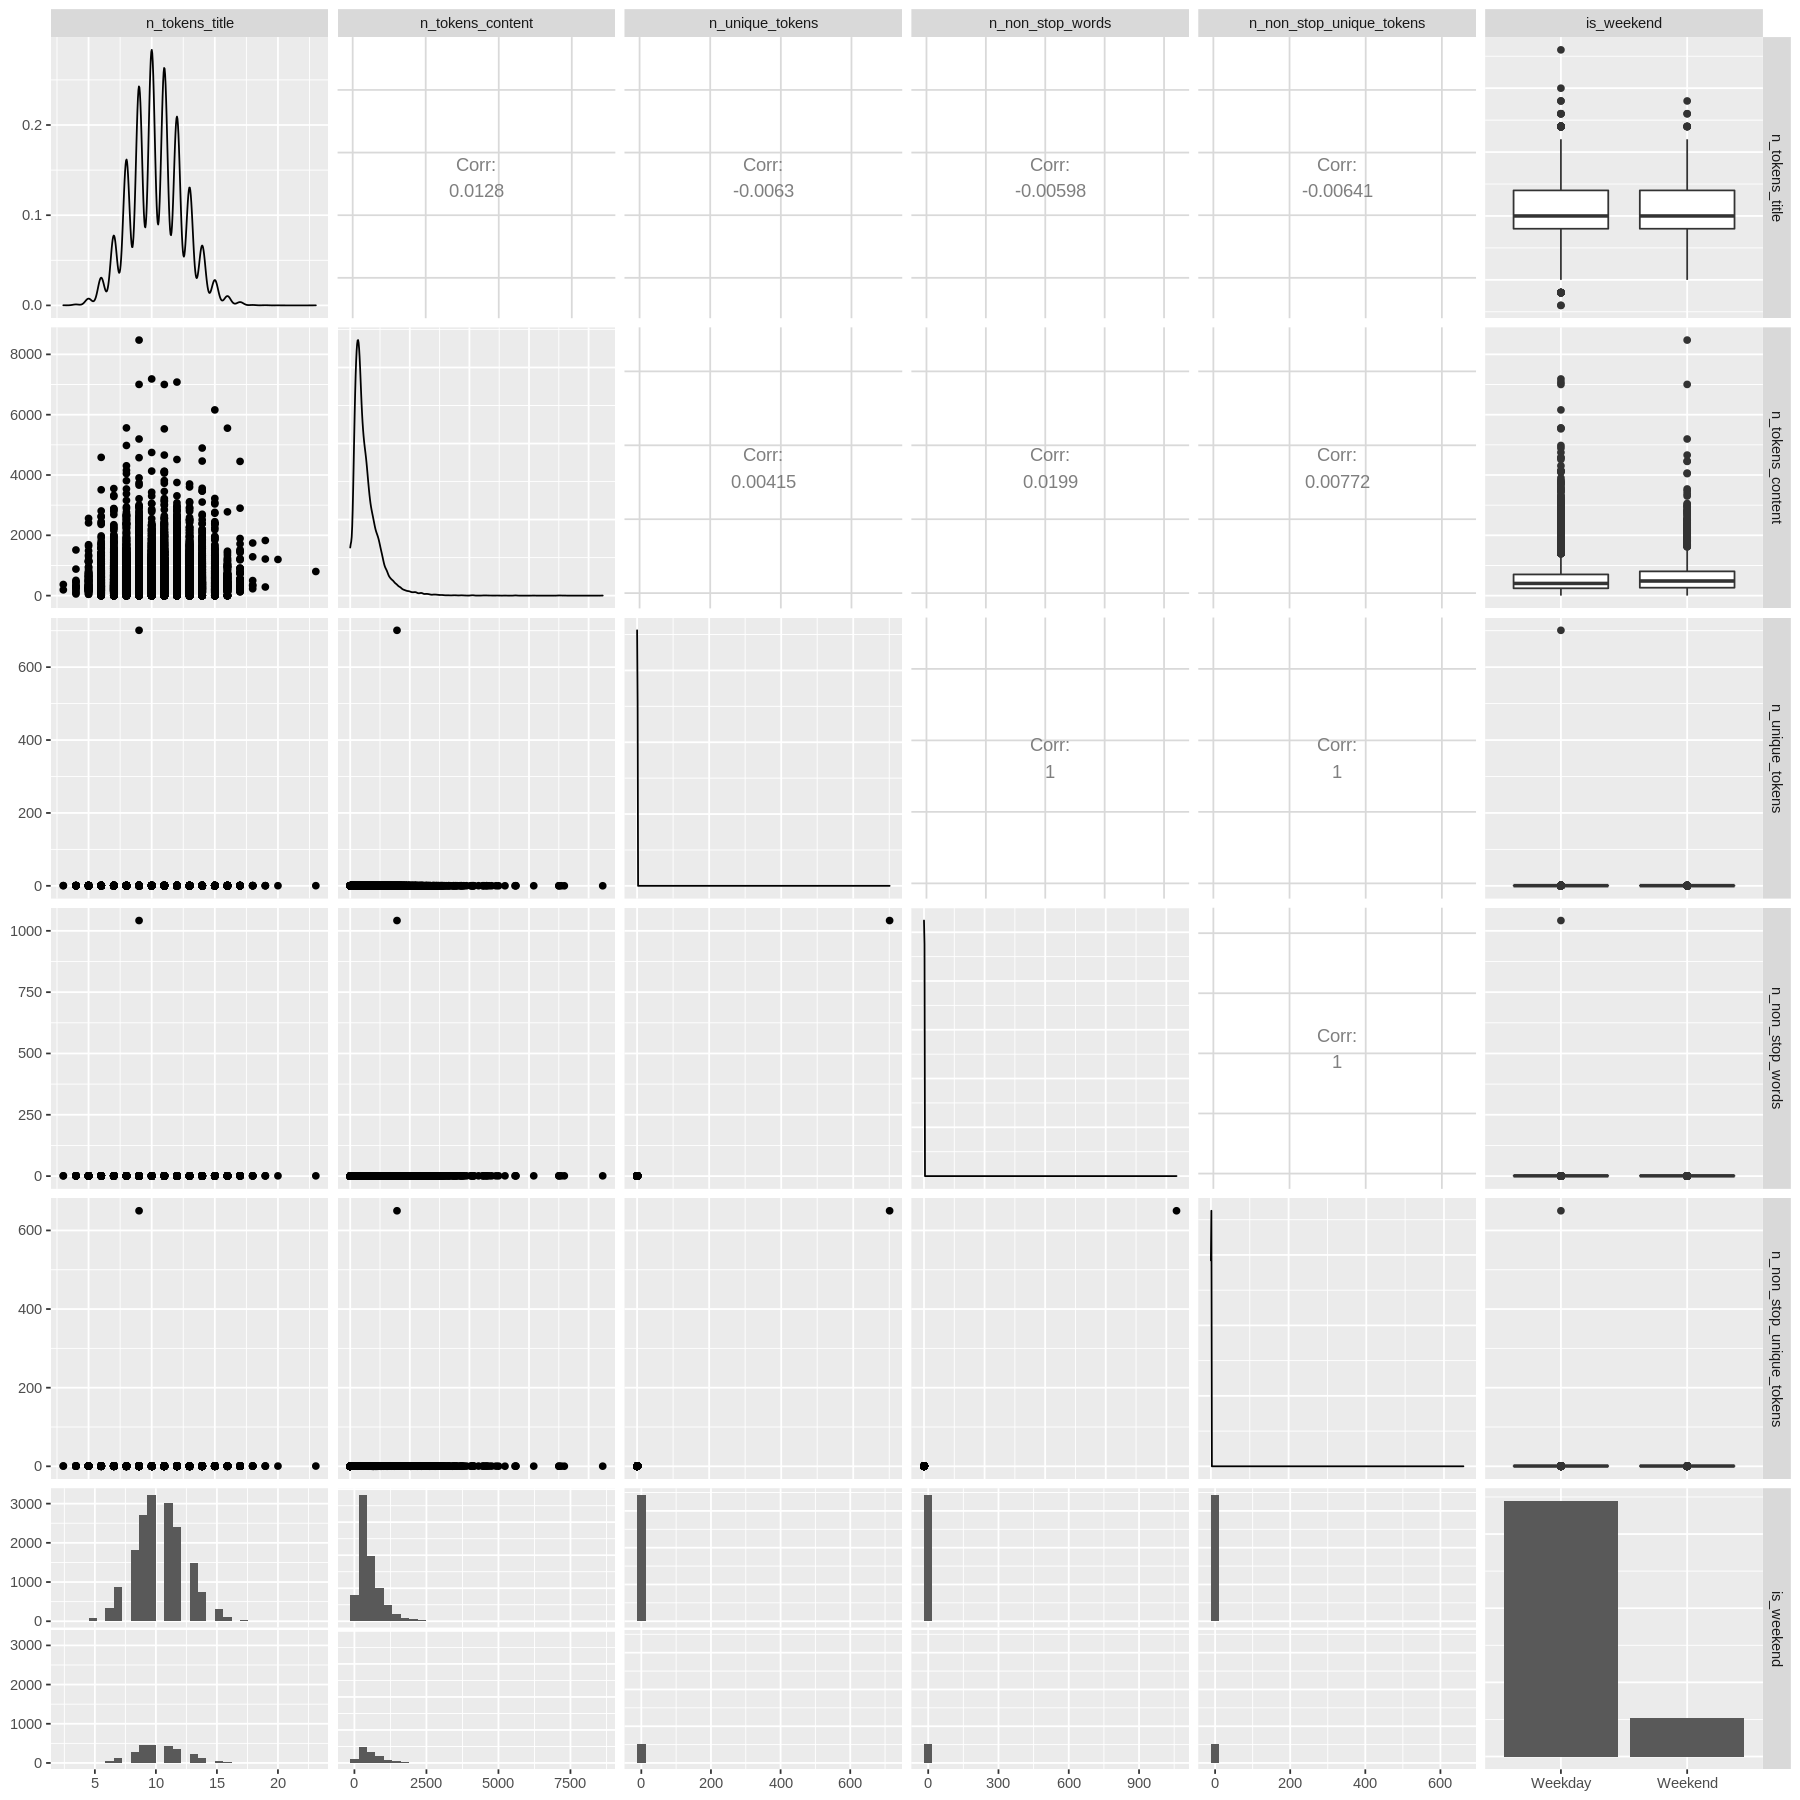

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15)

news_data_pairs1 <- news_train %>%
  select(n_tokens_title:n_non_stop_unique_tokens, is_weekend) %>%
  ggpairs()
news_data_pairs1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



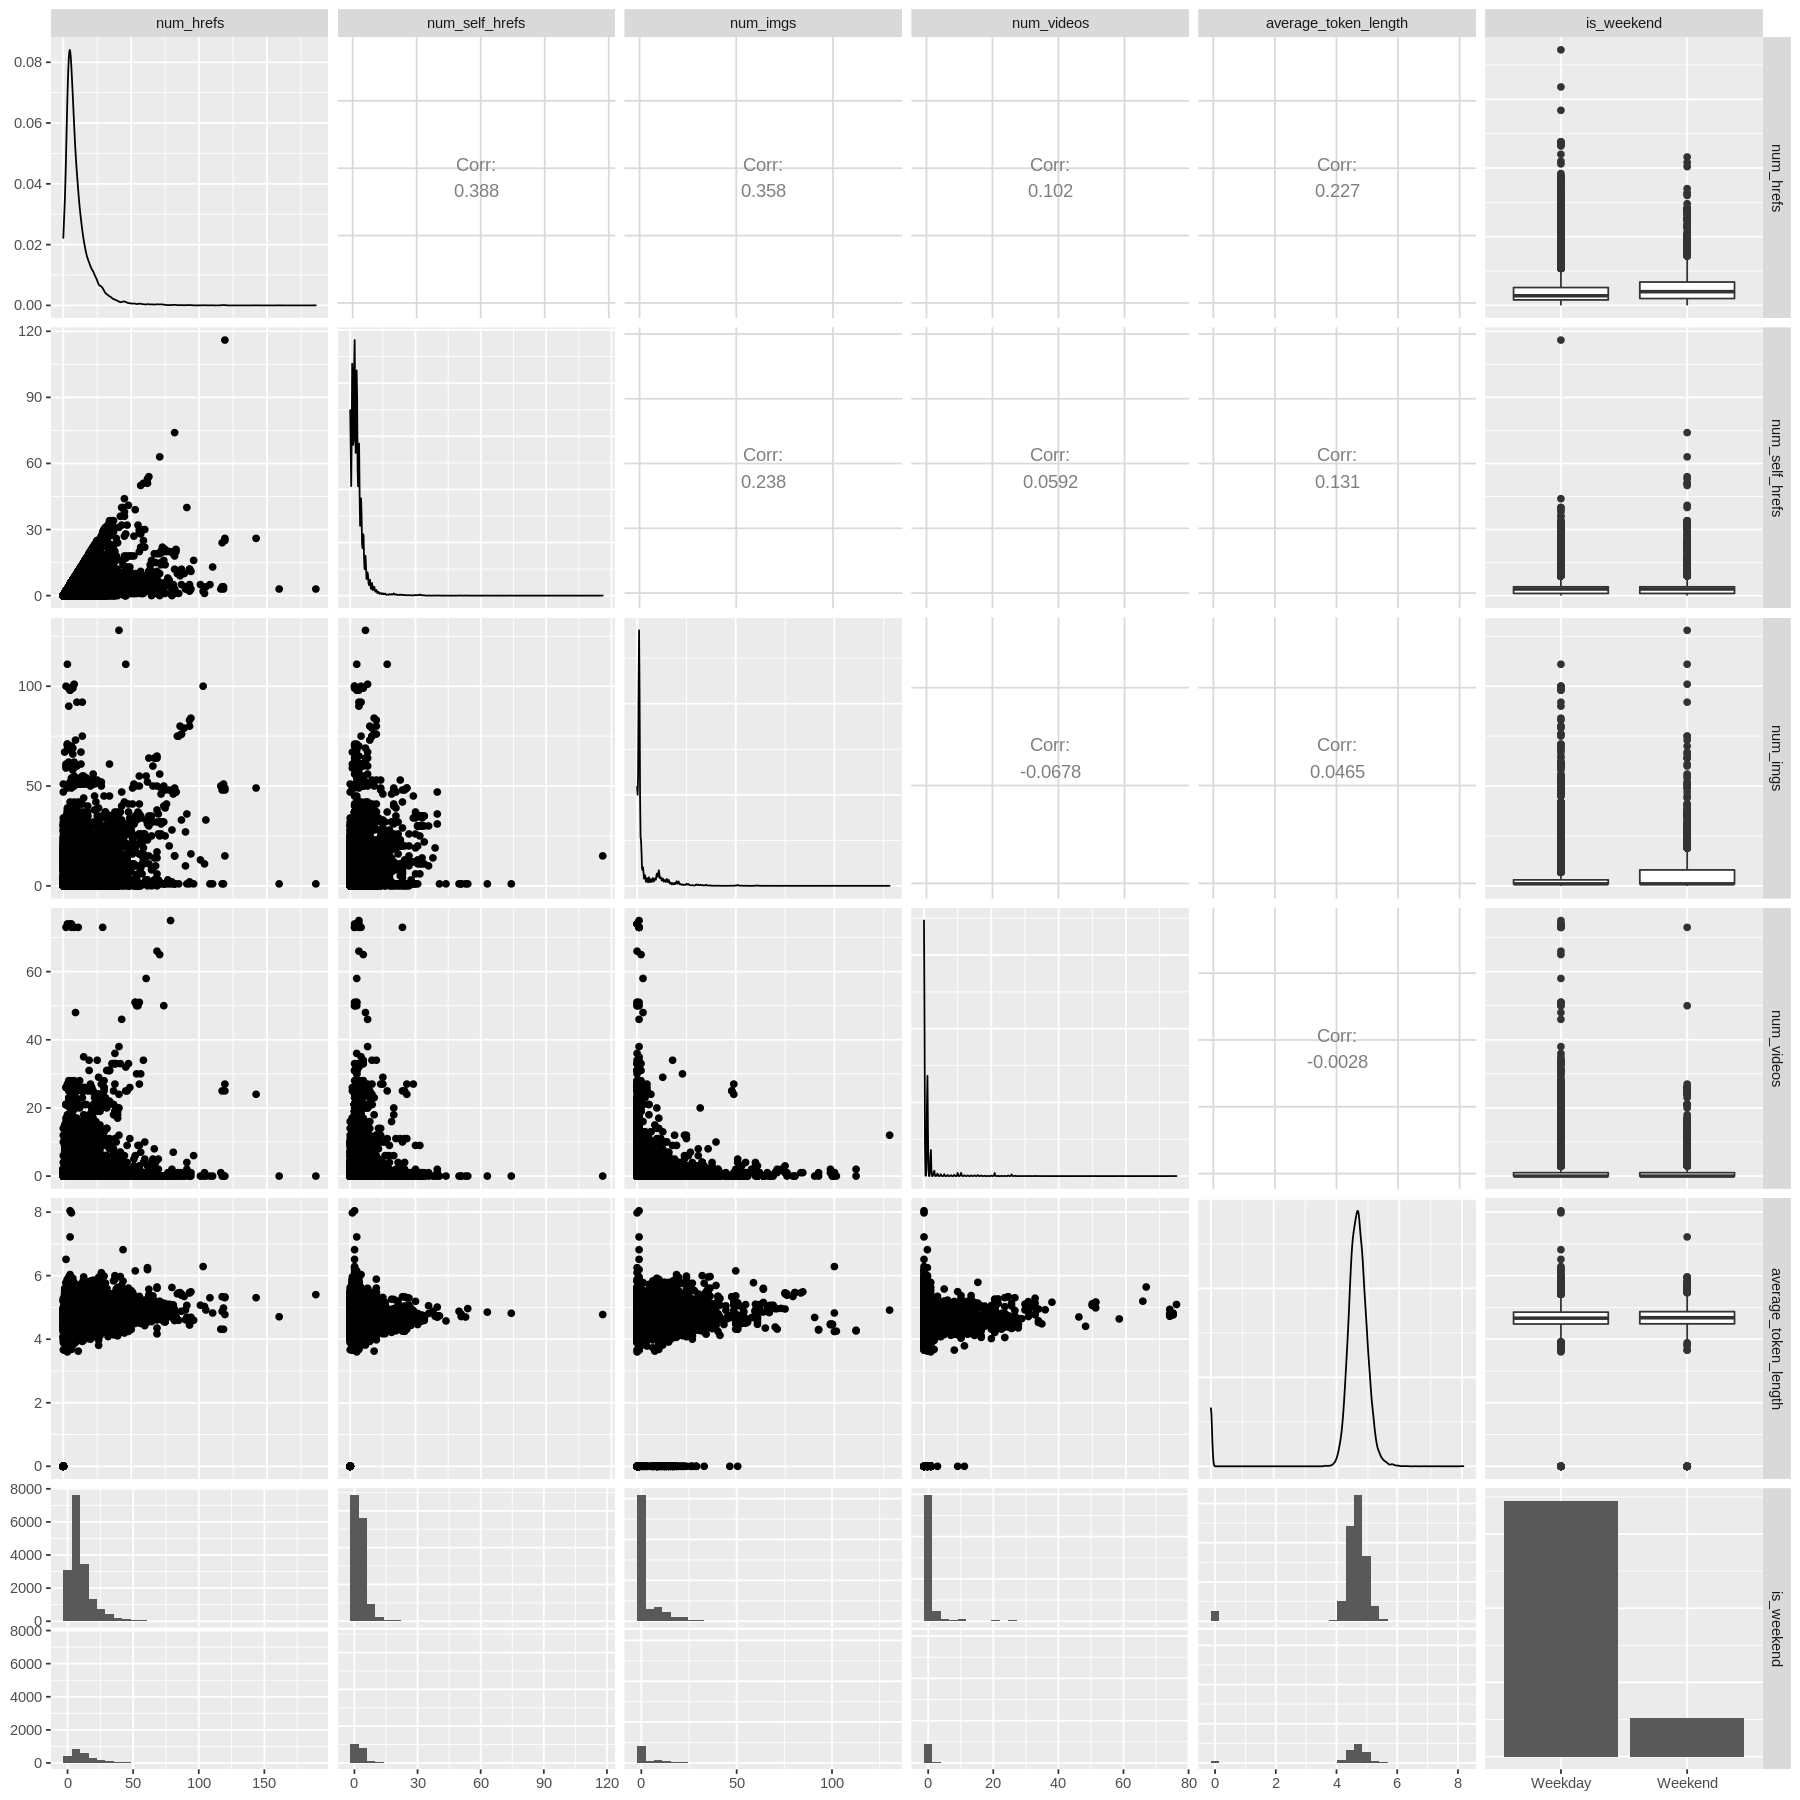

In [9]:
news_data_pairs2 <- news_train %>%
  select(num_hrefs:average_token_length, is_weekend) %>%
  ggpairs()
news_data_pairs2

In [10]:
news_data_pairs3 <- news_train %>%
  select(num_keywords:self_reference_avg_sharess, -c(data_channel_is_lifestyle:kw_avg_avg), is_weekend) %>%
  ggpairs()
news_data_pairs3

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `data_channel_is_lifestyle` doesn't exist.


In [ ]:
news_data_pairs4 <- news_train %>%
  select(global_subjectivity:rate_positive_words, is_weekend) %>%
  ggpairs()
news_data_pairs4

In [ ]:
news_data_pairs5 <- news_train %>%
  select(rate_negative_words:min_negative_polarity, is_weekend) %>%
  ggpairs()
news_data_pairs5

In [ ]:
news_data_pairs6 <- news_train %>%
  select(max_negative_polarity:shares, is_weekend) %>%
  ggpairs()
news_data_pairs6